In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=e35f

## 1. Import

In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET
import shutil, yaml, math, gc, contextlib
from pathlib import Path
from PIL import Image
import os

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm.auto import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", message="can only test a child process")

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
import torch.utils.data.dataloader as dataloader

# Monkey-patch to silence "can only test a child process" error
def patched_del(self):
    try:
        self._shutdown_workers()
    except Exception:
        pass

dataloader._MultiProcessingDataLoaderIter.__del__ = patched_del


In [4]:

BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_ssl_vit")
SPLIT = WORK / "0_yolo_split"
SSL_W = WORK / "dinov2_backbone.pth"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)


import random

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            # Convert to YOLO format
            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    # Wipe any old split to avoid stale empty folders
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    # Collect all image + xml pairs (support many extensions)
    all_pairs = []
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    for ext in exts:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))
    print(f"Found {len(all_pairs)} annotated images total.")

    if len(all_pairs) == 0:
        raise RuntimeError("❌ No image/xml pairs found. Check dataset path & extensions.")

    # Split into train/val/test
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "valid":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in your dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready.")


➤ Converting Pascal VOC → YOLO with auto split …
Found 23678 annotated images total.
train: 16574 images
valid: 4735 images
test: 2369 images
✓ YOLO split ready.


## 2. Augmentation

In [ ]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

## 3. YOLO V12s model backbone in dino-v2

In [ ]:
detector = YOLO("yolo12s.pt")   
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo12s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


## 4.projection head and loss function

In [ ]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


## 5. training loop with hyperparameter and optimizer

In [ ]:

EPOCHS     = 25      
BATCH      = 16
ACCUM      = 6
LR         = 1e-4
WD         = 0.05
EMA0       = 0.999
N_LOCAL    = 8
NUM_WORKERS= 2

# Point to your dataset
WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv12s backbone …")
    ds = MultiCropDINO([WORK/"train/images", WORK/"valid/images", WORK/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))
    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv12s backbone →", SSL_W)
    print("✓ DINOv2-style pretraining complete.\n")


 DINOv2-style pretraining on YOLOv12s backbone …


SSL Ep 1/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 01: loss=5.4226


SSL Ep 2/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 02: loss=4.5825


SSL Ep 3/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 03: loss=4.5048


SSL Ep 4/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 04: loss=4.5725


SSL Ep 5/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 05: loss=4.6366


SSL Ep 6/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 06: loss=4.7095


SSL Ep 7/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 07: loss=4.7540


SSL Ep 8/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 08: loss=4.7756


SSL Ep 9/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 09: loss=4.7831


SSL Ep 10/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 10: loss=4.7704


SSL Ep 11/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 11: loss=4.7527


SSL Ep 12/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 12: loss=4.7228


SSL Ep 13/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 13: loss=4.6852


SSL Ep 14/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.6537


SSL Ep 15/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.6169


SSL Ep 16/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 16: loss=4.5870


SSL Ep 17/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 17: loss=4.5651


SSL Ep 18/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 18: loss=4.5524


SSL Ep 19/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 19: loss=4.5334


SSL Ep 20/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.5118


SSL Ep 21/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 21: loss=4.5004


SSL Ep 22/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 22: loss=4.4895


SSL Ep 23/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 23: loss=4.4785


SSL Ep 24/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 24: loss=4.4661


SSL Ep 25/25:   0%|          | 0/1479 [00:00<?, ?it/s]

SSL Epoch 25: loss=4.4536


✓ Saved SSL YOLOv12s backbone → /kaggle/working/traffic_ssl_vit/dinov2_backbone.pth
✓ DINOv2-style pretraining complete.



## 6. Fine-Tuning with SSL Backbone

In [5]:
SSL_W = "/kaggle/input/pretexttask-dino-with-yolov12/yolov12/dinov2_backbone.pth"


det = YOLO("yolo12s.pt")  # fresh model
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(data=str(DATA),
          epochs=25,
          imgsz=640,
          batch=16,
          save=True,
          save_period=1,
          project=str(WORK),
          name="ssl_yolov12s_dinov2",
          device=0 if device=="cuda" else "cpu")

Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_ssl_vit/data_traffic.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov12s_dinov2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46545      0.699      0.698      0.749      0.517
              Rickshaw       3923      12107       0.79      0.854      0.903      0.626
                   Bus       3905      10581      0.795      0.837      0.893      0.651
                 Truck        255        283      0.545      0.481      0.513      0.399
                  Bike       2098       3155      0.763      0.786      0.852      0.522
                People       2926       7720      0.771      0.785      0.859      0.541
                   Car       4261      12554      0.832      0.885      0.934      0.703
                 Cycle        139        145      0.399      0.255      0.288      0.178
Speed: 0.1ms preprocess, 5.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/traffic_ssl_vit/ssl_yolov12s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e9dfda24b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## 7. Loss Curve Visualization

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


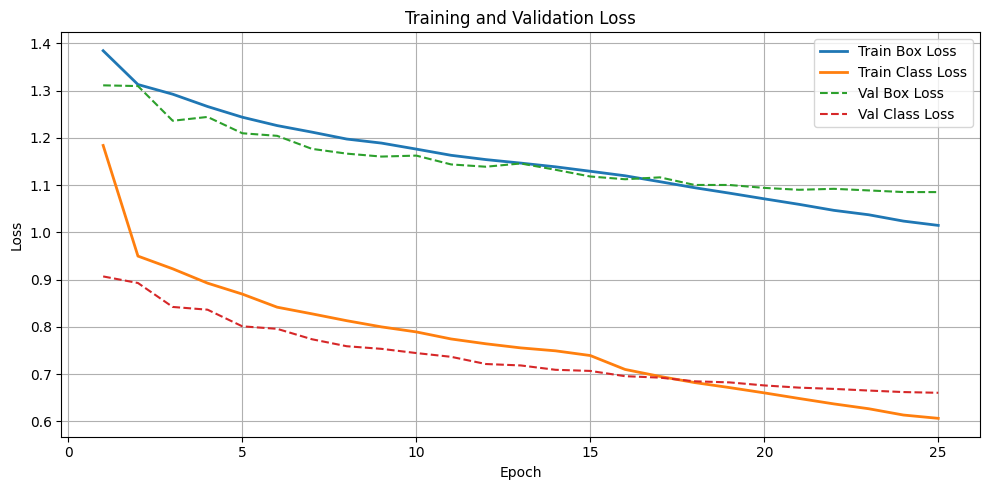

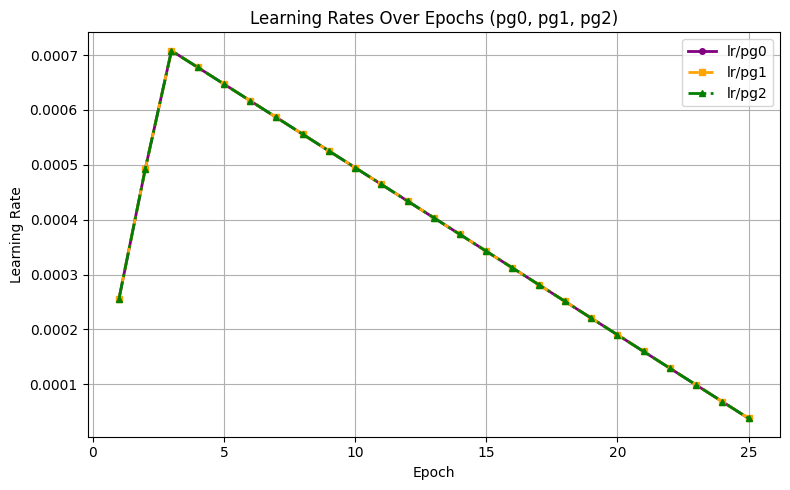

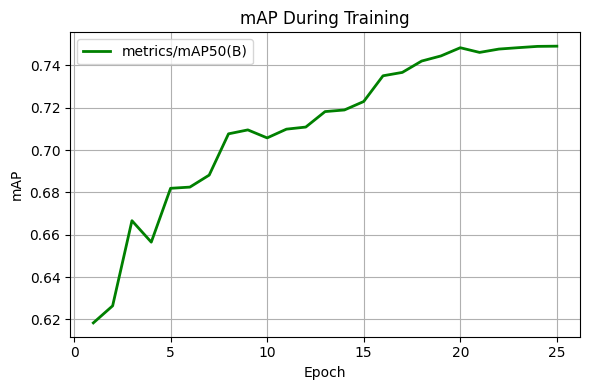

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

WORK2 = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split") 

# Path to results.csv
results_path = WORK / "ssl_yolov12s_dinov2" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


## 8. Detection

Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1615.3±345.0 MB/s, size: 66.8 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 11 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 8604865.4it/s 0.0s
val: /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/images/frame1_jpg.rf.af73293c83d849389bfeacd60c71cd38.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 18.5it/s 1:04


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46545      0.696      0.699      0.749      0.517
              Rickshaw       3923      12107      0.789      0.855      0.903      0.626
                   Bus       3905      10581      0.793      0.838      0.893      0.651
                 Truck        255        283      0.537      0.484      0.513      0.398
                  Bike       2098       3155      0.761      0.788      0.852      0.522
                People       2926       7720      0.769      0.787      0.859      0.541
                   Car       4261      12554      0.831      0.886      0.934      0.703
                 Cycle        139        145      0.393      0.255      0.288      0.178
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.6962
 Recall    (mR) : 0.6990
 mAP@0.50      : 0.7489
 mAP@0.50-0.95 : 0.5169


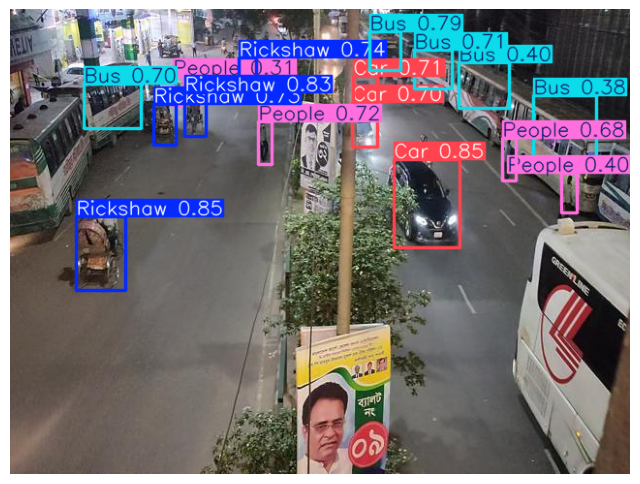

In [7]:
best_pt = WORK / "ssl_yolov12s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)




WORK3  = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")


# visualize a random test image
test_imgs = list((WORK3/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")